<a href="https://colab.research.google.com/github/rbncosta/RobsonCosta_FIAP_RM565066_fase5/blob/main/RobsonCosta_rm565066_pbl_fase5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FarmTech Solutions — Previsão de Rendimento de Safra (Fase 5)

Notebook final com EDA, clusterização, outliers, **5 modelos**, métricas (CV leve e hold-out) e **diagnósticos** (resíduos e importâncias).

## 1) Imports & Funções auxiliares

In [1]:

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
np.random.seed(42)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}


## 2) Carregamento do dataset e padronização

In [2]:

CANDIDATE_PATHS = ["/mnt/data/crop_yield.csv", os.path.join("data","crop_yield.csv"), "crop_yield.csv"]
DATA_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("Adicione 'crop_yield.csv' em data/ ou no diretório atual.")

df = pd.read_csv(DATA_PATH).rename(columns={
    "Crop": "Cultura",
    "Precipitation (mm day-1)": "Precipitacao_mm_dia",
    "Specific Humidity at 2 Meters (g/kg)": "Umidade_especifica_2m_gkg",
    "Relative Humidity at 2 Meters (%)": "Umidade_relativa_2m_pct",
    "Temperature at 2 Meters (C)": "Temperatura_2m_C",
    "Yield": "Rendimento_ton_ha",
})
for c in ["Precipitacao_mm_dia","Umidade_especifica_2m_gkg","Umidade_relativa_2m_pct","Temperatura_2m_C","Rendimento_ton_ha"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("Lido de:", DATA_PATH, "| formato:", df.shape)
df.head()


Lido de: data/crop_yield.csv | formato: (156, 6)


,Cultura,Precipitacao_mm_dia,Umidade_especifica_2m_gkg,Umidade_relativa_2m_pct,Temperatura_2m_C,Rendimento_ton_ha
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 3) Análise Exploratória de Dados rápida

In [3]:

display(df.describe(include='all'))
print("\nMissing por coluna:\n", df.isna().sum())
print("\nCulturas:\n", df["Cultura"].value_counts())


,Cultura,Precipitacao_mm_dia,Umidade_especifica_2m_gkg,Umidade_relativa_2m_pct,Temperatura_2m_C,Rendimento_ton_ha
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000



Missing por coluna:
 Cultura                      0
Precipitacao_mm_dia          0
Umidade_especifica_2m_gkg    0
Umidade_relativa_2m_pct      0
Temperatura_2m_C             0
Rendimento_ton_ha            0
dtype: int64

Culturas:
 Cultura
Cocoa, beans       39
Oil palm fruit     39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64


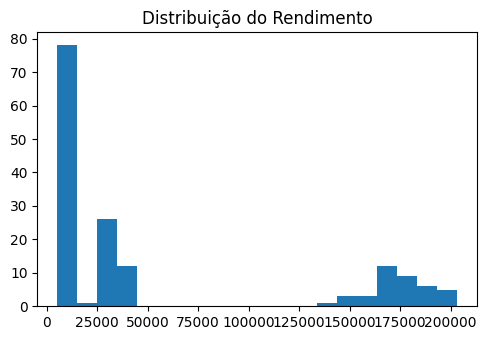

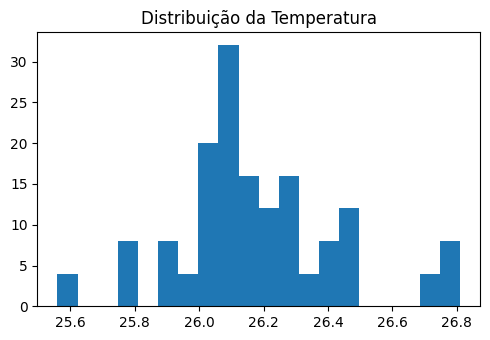

In [4]:

fig, ax = plt.subplots(figsize=(5,3.5))
ax.hist(df["Rendimento_ton_ha"].dropna(), bins=20); ax.set_title("Distribuição do Rendimento"); plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(5,3.5))
ax.hist(df["Temperatura_2m_C"].dropna(), bins=20); ax.set_title("Distribuição da Temperatura"); plt.tight_layout(); plt.show()


## 4) Correlações numéricas - mede o quanto duas variáveis numéricas se relacionam entre si.

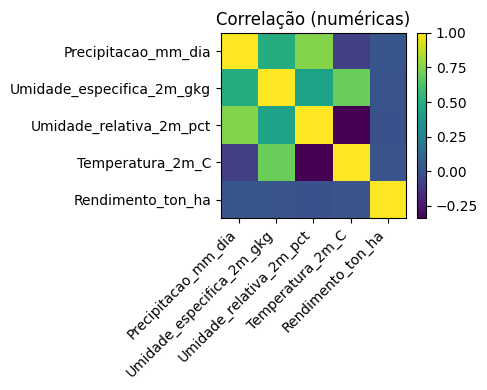

,Precipitacao_mm_dia,Umidade_especifica_2m_gkg,Umidade_relativa_2m_pct,Temperatura_2m_C,Rendimento_ton_ha
Precipitacao_mm_dia,1.000000,0.488483,0.749464,-0.083927,0.018830
Umidade_especifica_2m_gkg,0.488483,1.000000,0.436687,0.699230,0.012651
Umidade_relativa_2m_pct,0.749464,0.436687,1.000000,-0.337313,0.000008
Temperatura_2m_C,-0.083927,0.699230,-0.337313,1.000000,0.013007
Rendimento_ton_ha,0.018830,0.012651,0.000008,0.013007,1.000000


In [5]:

NUM_COLS = ["Precipitacao_mm_dia","Umidade_especifica_2m_gkg","Umidade_relativa_2m_pct","Temperatura_2m_C"]
TARGET_COL = "Rendimento_ton_ha"
corr = df[NUM_COLS + [TARGET_COL]].corr(numeric_only=True)

plt.figure(figsize=(5,4))
im = plt.imshow(corr, interpolation='nearest'); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right'); plt.yticks(range(len(corr)), corr.index)
plt.title("Correlação (numéricas)"); plt.tight_layout(); plt.show()

corr


## 5) Clusterização (KMeans + PCA) - aprendizado não supervisionado que agrupa dados semelhantes sem precisar de rótulos

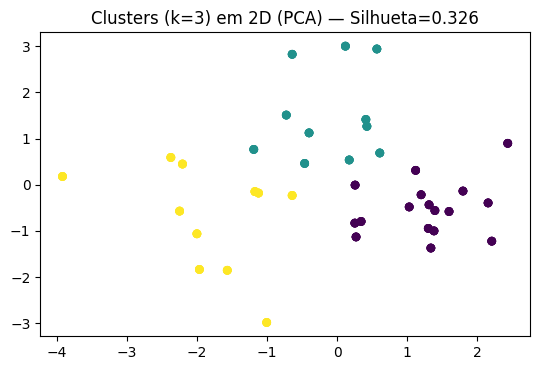

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,68.0,56736.544118,71004.809259,5249.0,8219.75,19153.5,68694.50,199074.0
1,44.0,57453.000000,72263.521555,5571.0,7762.00,20158.0,67518.75,203399.0
2,44.0,53951.500000,69220.556028,5765.0,9217.50,18123.0,60045.50,201436.0


In [6]:

from sklearn.metrics import silhouette_score

CAT_COLS = ["Cultura"]
pre_clust = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
                               ("num", StandardScaler(), NUM_COLS)], remainder="drop")
Xc = pre_clust.fit_transform(df[CAT_COLS + NUM_COLS])

best_k, best_s = None, -1
for k in [2,3]:
    lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Xc)
    s = silhouette_score(Xc, lab)
    if s > best_s: best_k, best_s = k, s

labels = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit_predict(Xc)
Xp = PCA(n_components=2, random_state=42).fit_transform(Xc.toarray() if hasattr(Xc,"toarray") else Xc)

plt.figure(figsize=(5.5,3.8))
plt.scatter(Xp[:,0], Xp[:,1], c=labels, s=28)
plt.title(f"Clusters (k={best_k}) em 2D (PCA) — Silhueta={best_s:.3f}")
plt.tight_layout(); plt.show()

df["cluster"] = labels
df.groupby("cluster")[TARGET_COL].describe()


## 6) Outliers (IsolationForest)

In [7]:

iso = IsolationForest(random_state=42, contamination=0.05)
df["outlier"] = (iso.fit_predict(df[NUM_COLS]) == -1)
print("Proporção de outliers:", round(df["outlier"].mean(), 3))
df[df["outlier"]].head()


Proporção de outliers: 0.051


,Cultura,Precipitacao_mm_dia,Umidade_especifica_2m_gkg,Umidade_relativa_2m_pct,Temperatura_2m_C,Rendimento_ton_ha,cluster,outlier
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,2,True
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,2,True
40,Oil palm fruit,1938.42,17.54,82.11,26.11,201436,2,True
42,Oil palm fruit,2592.35,17.61,85.07,25.56,181826,2,True
79,"Rice, paddy",1938.42,17.54,82.11,26.11,27619,2,True


## 7) Modelagem — 5 algoritmos (Validação Cruzada leve)

In [8]:

from collections import OrderedDict
X = df[["Cultura"] + NUM_COLS]; y = df[TARGET_COL]

pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), ["Cultura"]),
                         ("num", StandardScaler(), NUM_COLS)], remainder="drop")

models = OrderedDict([
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.001, max_iter=5000)),
    ("DecisionTree", DecisionTreeRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
])

kf = KFold(n_splits=2, shuffle=True, random_state=42)  # leve
rows = []
for name, est in models.items():
    pipe_tmp = Pipeline([("pre", pre), ("model", est)])
    r2 = cross_val_score(pipe_tmp, X, y, cv=kf, scoring="r2").mean()
    rows.append({"Modelo": name, "R2": r2})

metrics_df = pd.DataFrame(rows).set_index("Modelo").sort_values("R2", ascending=False)
display(metrics_df)

best_name = metrics_df.index[0]
best_name


,R2
Modelo,
Lasso,0.985594
LinearRegression,0.985588
Ridge,0.983859
GradientBoosting,0.979803
DecisionTree,0.977327


'Lasso'

## 8) Hold-out (20%) no melhor modelo

In [9]:

best_map = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}
best_est = best_map[best_name]

pipe = Pipeline([("pre", pre), ("model", best_est)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
y_pred_test = pipe.predict(X_test)

final_metrics = regression_metrics(y_test, y_pred_test)
print("Melhor modelo:", best_name)
print("Métricas em hold-out (20%):", final_metrics)


Melhor modelo: Lasso
Métricas em hold-out (20%): {'MAE': 3150.2913676896283, 'RMSE': 4405.861216627607, 'R2': 0.9949956806277837}


## 9) Diagnóstico: Consistência com a Validação Cruzada (R² apenas, leve)

In [10]:

cv_r2  = cross_val_score(pipe, X, y, cv=KFold(n_splits=2, shuffle=True, random_state=42), scoring="r2")
print("CV R2  (mean ± std):", cv_r2.mean(),  cv_r2.std())


CV R2  (mean ± std): 0.9855941173416541 7.965743563420613e-05


## 10) Diagnóstico: Resíduos no hold-out

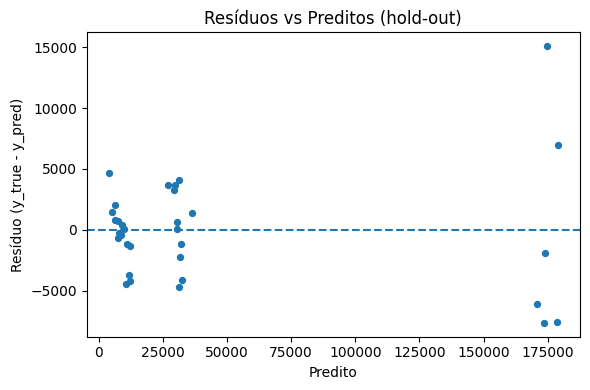

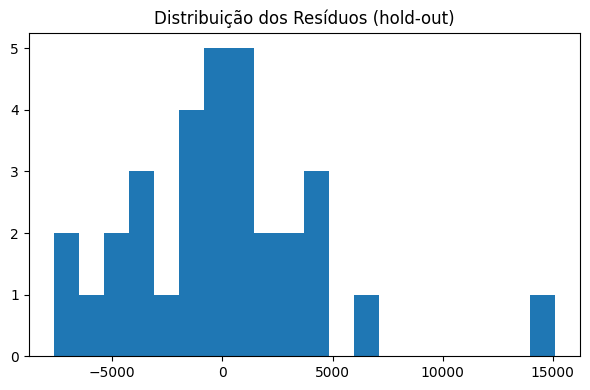

In [11]:

resid = y_test - y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, resid, s=18)
plt.axhline(0, linestyle="--")
plt.title("Resíduos vs Preditos (hold-out)")
plt.xlabel("Predito"); plt.ylabel("Resíduo (y_true - y_pred)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid, bins=20)
plt.title("Distribuição dos Resíduos (hold-out)")
plt.tight_layout(); plt.show()


## 11) Diagnóstico: Importância das variáveis (se disponível)

In [12]:

model = pipe.named_steps["model"]
has_importance = hasattr(model, "feature_importances_")
print("Modelo possui feature_importances_?", has_importance)

if has_importance:
    preproc = pipe.named_steps["pre"]
    try:
        cat_names = preproc.named_transformers_["cat"].get_feature_names_out(["Cultura"])
    except:
        cat_names = preproc.named_transformers_["cat"].get_feature_names(["Cultura"])
    num_names = np.array(["Precipitacao_mm_dia","Umidade_especifica_2m_gkg","Umidade_relativa_2m_pct","Temperatura_2m_C"])
    feat_names = np.concatenate([cat_names, num_names])

    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1]

    print("\nTop 15 features por importância:")
    for i in idx[:15]:
        print(f"{feat_names[i]}: {importances[i]:.4f}")
else:
    print("O modelo selecionado não expõe importâncias de features (ex.: LinearRegression/Lasso).")


Modelo possui feature_importances_? False
O modelo selecionado não expõe importâncias de features (ex.: LinearRegression/Lasso).
